<a href="https://colab.research.google.com/github/AndySCS/ZW02a-25_FYP_repo/blob/20251225_ffn_test/ffn_test/jpnb/FYP_MINST_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import pkgs

In [ ]:
pip install ai_edge_litert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 69.3 MB/s eta 0:00:00


In [ ]:
#import pkgs
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
from ai_edge_litert.interpreter import Interpreter

#define model

In [ ]:
#model def
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#load ds

In [ ]:
# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Normalize the dataset
x_train, x_test = x_train / 255.0, x_test / 255.0

#train model

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(x_train, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7931 - loss: 0.6679 - val_accuracy: 0.9459 - val_loss: 0.1878
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9228 - loss: 0.2579 - val_accuracy: 0.9586 - val_loss: 0.1433
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9388 - loss: 0.2071 - val_accuracy: 0.9639 - val_loss: 0.1250
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9460 - loss: 0.1755 - val_accuracy: 0.9662 - val_loss: 0.1150
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9514 - loss: 0.1583 - val_accuracy: 0.9689 - val_loss: 0.1043


In [ ]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(x_test, y_test)

# Print the test accuracy
print(f'Test accuracy: {test_acc:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9638 - loss: 0.1177
Test accuracy: 0.9687


In [ ]:
# Make predictions on the test data
predictions = model.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


#eval model

In [ ]:
# Plot training & validation accuracy values
def show_acc_history(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

In [ ]:
# Plot training & validation loss values
def show_val_history(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

In [ ]:
def show_history(history):
  show_acc_history(history)
  show_val_history(history)

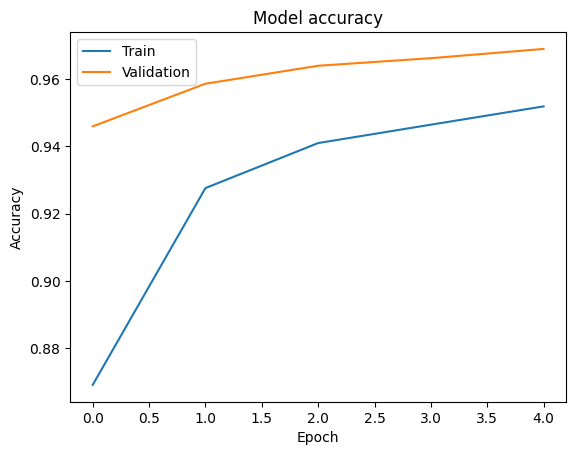

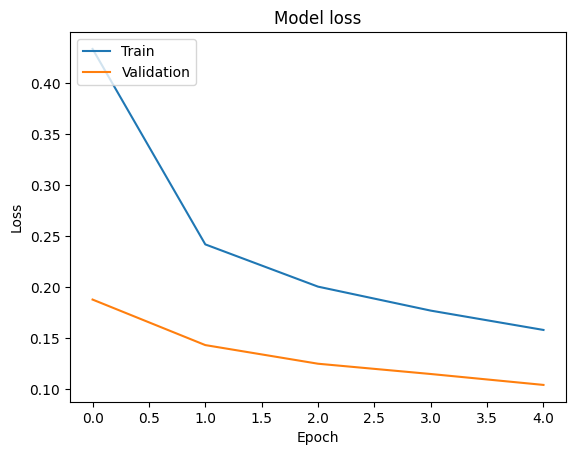

In [ ]:
show_history(history)

#convert to int8

##build converter

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_test.astype('float32')).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

Saved artifact at '/tmp/tmpnzpasp81'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132872321023632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132872321023824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132872321023440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132872303019600: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


##convert model

In [ ]:


tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

108136

##evaluate int8 model

In [ ]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices, x_test, y_test):

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = x_test[test_image_index]
    test_label = x_test[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions

In [ ]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type, x_test, y_test):

  test_image_indices = range(x_test.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices, x_test, y_test)

  accuracy = (np.sum(y_test== predictions) * 100) / len(x_test)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(x_test)))

In [ ]:
evaluate_model(tflite_model_quant_file, model_type="Quantized", x_test = x_test, y_test = y_test)

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Quantized model accuracy is 96.8700% (Number of test samples=10000)


#download int8 model

##extract weights and biases

In [ ]:
def quantize_tensor(tensor, n_bits=8, signed=True):
    """Quantize a tensor to specified bit width"""
    if signed:
        qmin, qmax = -(2**(n_bits-1)), 2**(n_bits-1) - 1
    else:
        qmin, qmax = 0, 2**n_bits - 1

    # Find the range of the tensor
    tmin, tmax = tensor.min(), tensor.max()
    scale = (tmax - tmin) / (qmax - qmin)
    zero_point = qmin - (tmin / scale)

    # Quantize
    quantized = np.clip(np.round(tensor / scale + zero_point), qmin, qmax).astype(np.int8)

    return quantized, scale, zero_point

In [ ]:

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter.allocate_tensors()

# Get a list of all tensor details in the model
all_layers_details = interpreter.get_tensor_details()

model_weights = []
model_biases = []
model_scale_and_zero = []

# Iterate through the details to identify and extract weight tensors
for tensor_details in all_layers_details:
    #print(tensor_details['name'])
    # Check if the tensor contains weights (usually memory-mapped read-only)
    # The 'name' often indicates if it's a kernel (weights) or bias
    if "pseudo_qconst" in tensor_details['name'] or "bias" in tensor_details['name']:
        tensor_index = tensor_details['index']
        # Get the actual data (weights) as a NumPy array
        weights = interpreter.get_tensor(tensor_index)
        """
        print(f"Tensor Name: {tensor_details['name']}")
        print(f"Shape: {weights.shape}")
        print(f"Dtype: {weights.dtype}")
        """
        if weights.dtype == np.int8:
          model_weights.append(weights)
        elif weights.dtype == np.int32:
          qquant_weight, scale, zero_point = quantize_tensor(weights, n_bits=8, signed=True)
          model_biases.append(qquant_weight)
          model_scale_and_zero.append({'scale':scale, 'zero':zero_point})
        #print(f"Weights (first few values): {weights.flatten()[:5]}\n")

        # If the model is quantized, you can also access quantization parameters
        quant_params = tensor_details['quantization_parameters']

for weight in model_weights:
  print(weight.shape)

for bias in model_biases:
  print(bias.shape)

for bias in model_scale_and_zero:
  print(bias)



(10, 128)
(128, 784)
(10,)
(128,)
{'scale': np.float64(12.419607843137255), 'zero': np.float64(41.65108935901483)}
{'scale': np.float64(191.1921568627451), 'zero': np.float64(-1.9174221602330022)}


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


##save param to csv

In [ ]:
import csv

In [ ]:
def save_csv(tensor, file_dir):
  print(tensor.dtype)
  np.savetxt(file_dir, tensor, delimiter=',', fmt='%d')

In [ ]:
def save_dict_to_csv(write_dict, file_dir):
  my_dict = list(write_dict.keys())
  print(my_dict)

  # Open the file in write mode
  with open(file_dir, 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=my_dict)
    writer.writeheader()
    writer.writerow(write_dict)

In [ ]:
save_csv(model_weights[0], "mnist_kernel_128_10.csv")
save_csv(model_weights[1], "mnist_kernel_784_128.csv")
save_csv(model_biases[0], "mnist_bias_128_10.csv")
save_csv(model_biases[1], "mnist_bias_784_128.csv")
save_dict_to_csv(model_scale_and_zero[0], "mnist_scale_and_zero_128_10.csv")
save_dict_to_csv(model_scale_and_zero[1], "mnist_scale_and_zero_784_128.csv")



int8
int8
int8
int8
['scale', 'zero']
['scale', 'zero']


In [ ]:
from google.colab import files
files.download("mnist_kernel_128_10.csv")
files.download("mnist_kernel_784_128.csv")
files.download("mnist_bias_128_10.csv")
files.download("mnist_bias_784_128.csv")
files.download("mnist_scale_and_zero_128_10.csv")
files.download("mnist_scale_and_zero_784_128.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>